# Question 4 - Predictive Analytic Tasks

## Import Libraries

In [1]:
from urllib import request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest

Matplotlib is building the font cache; this may take a moment.


## Load Data

In [2]:
# download data from s3 bucket and save in local memory

url = 'https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/sr_hex.csv.gz'
request.urlretrieve(url = url, filename = url.split('/')[-1])

('sr_hex.csv.gz', <http.client.HTTPMessage at 0x7f0240af03d0>)

In [3]:
# decompress and read file

df = pd.read_csv('sr_hex.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
df

,notification_number,reference_number,creation_timestamp,completion_timestamp,directorate,department,branch,section,code_group,code,cause_code_group,cause_code,official_suburb,latitude,longitude,h3_level8_index
0,400583534,9.109492e+09,2020-10-07 06:55:18+02:00,2020-10-08 15:36:35+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area Central,District: Blaauwberg,TD Customer complaint groups,Pothole&Defect Road Foot Bic Way/Kerbs,Road (RCL),Wear and tear,MONTAGUE GARDENS,-33.872839,18.522488,88ad360225fffff
1,400555043,9.108995e+09,2020-07-09 16:08:13+02:00,2020-07-14 14:27:01+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area East,District : Somerset West,TD Customer complaint groups,Manhole Cover/Gully Grid,Road (RCL),Vandalism,SOMERSET WEST,-34.078916,18.848940,88ad36d5e1fffff
2,400589145,9.109614e+09,2020-10-27 10:21:59+02:00,2020-10-28 17:48:15+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area East,District : Somerset West,TD Customer complaint groups,Manhole Cover/Gully Grid,Road (RCL),Vandalism,STRAND,-34.102242,18.821116,88ad36d437fffff
3,400538915,9.108601e+09,2020-03-19 06:36:06+02:00,2021-03-29 20:34:19+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area North,District : Bellville,TD Customer complaint groups,Paint Markings Lines&Signs,Road Markings,Wear and tear,RAVENSMEAD,-33.920019,18.607209,88ad361133fffff
4,400568554,NaN,2020-08-25 09:48:42+02:00,2020-08-31 08:41:13+02:00,URBAN MOBILITY,Roads Infrastructure Management,RIM Area South,District : Athlone,TD Customer complaint groups,Pothole&Defect Road Foot Bic Way/Kerbs,Road (RCL),Surfacing failure,CLAREMONT,-33.987400,18.453760,88ad361709fffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941629,1016508425,9.109974e+09,2020-12-31 23:49:38+02:00,2021-01-11 11:54:42+02:00,WATER AND SANITATION,Distribution Services,Reticulation,Reticulation Water Distribution,WATER,Leak at Valve,NaN,NaN,WOODSTOCK,-33.931571,18.452159,88ad361547fffff
941630,1016508432,9.109975e+09,2020-12-31 23:31:11+02:00,2021-01-04 11:46:28+02:00,WATER AND SANITATION,Distribution Services,Reticulation,NaN,SEWER,Sewer: Blocked/Overflow,General,Foreign Objects,FISANTEKRAAL,-33.783246,18.716554,88ad3656d7fffff
941631,1016508434,9.109975e+09,2020-12-31 23:58:21+02:00,2021-01-01 00:01:08+02:00,WATER AND SANITATION,Distribution Services,Reticulation,NaN,WATER,Burst Pipe,NaN,NaN,NaN,NaN,NaN,0
941632,1016508442,9.109975e+09,2020-12-31 23:41:57+02:00,2021-01-05 15:59:24+02:00,WATER AND SANITATION,Commercial Services,Customer Services (Water),Meter Management,WATER MANAGEMENT DEVICE,No Water WMD,NaN,NaN,WESBANK,-33.971099,18.659831,88ad36c49bfffff


## Question 4 Part 7 - Classification Challenge

### Exploratory Data Analysis

In [4]:
# missing data

def missing_values(df):
    '''
    tracks missing values from input df
    
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False)
    print ("[INFO] the dataframe has " + str(df.shape[1]) + " columns in total and " +
           str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

missing_values(df)

[INFO] the dataframe has 16 columns in total and 11 columns that have missing values.


,Missing Values,% of Total Values
cause_code_group,810517,86.075588
cause_code,810517,86.075588
reference_number,348714,37.032860
official_suburb,212413,22.557915
latitude,212364,22.552712
longitude,212364,22.552712
section,93125,9.889724
branch,28401,3.016140
completion_timestamp,12192,1.294771
department,9454,1.003999


In [5]:
# data types in each field

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941634 entries, 0 to 941633
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   notification_number   941634 non-null  int64  
 1   reference_number      592920 non-null  float64
 2   creation_timestamp    941634 non-null  object 
 3   completion_timestamp  929442 non-null  object 
 4   directorate           932199 non-null  object 
 5   department            932180 non-null  object 
 6   branch                913233 non-null  object 
 7   section               848509 non-null  object 
 8   code_group            941634 non-null  object 
 9   code                  941634 non-null  object 
 10  cause_code_group      131117 non-null  object 
 11  cause_code            131117 non-null  object 
 12  official_suburb       729221 non-null  object 
 13  latitude              729270 non-null  float64
 14  longitude             729270 non-null  float64
 15  

In [6]:
# summary statistics

categorical_features = df.columns.to_list()
no_analysis = ['notification_number',
               'reference_number',
               'creation_timestamp',
               'completion_timestamp',
               'latitude',
               'longitude']
[categorical_features.remove(feature) for feature in no_analysis]

df[categorical_features].describe()

,directorate,department,branch,section,code_group,code,cause_code_group,cause_code,official_suburb,h3_level8_index
count,932199,932180,913233,848509,941634,941634,131117,131117,729221,941634
unique,12,20,39,86,38,492,43,183,775,2083
top,WATER AND SANITATION,Electricity Generation and Distribution,Reticulation,Reticulation WW Conveyance,ELECTRICITY TECHNICAL COMPLAINTS,Sewer: Blocked/Overflow,General,Foreign Objects,PHILIPPI,0
freq,422834,278117,249234,124392,241017,134429,78197,25030,24647,212364


### Data Preparation

In [7]:
# prepare data

df['volume'] = 1 # measure of service request volume
df = df.sort_values(by = 'creation_timestamp', ascending = True) # sort by date
df.index = pd.DatetimeIndex(df['creation_timestamp']).tz_localize(None) # enable date manipulation and remove timezone
# df = df[~df['department'].isnull()] # remove unknown department (amounts to 1%) - alternative to line below
df.replace(np.NaN, 'Unknown Department', inplace = True) # keep track of unknown departments as well
df

,notification_number,reference_number,creation_timestamp,completion_timestamp,directorate,department,branch,section,code_group,code,cause_code_group,cause_code,official_suburb,latitude,longitude,h3_level8_index,volume
creation_timestamp,,,,,,,,,,,,,,,,,
2020-01-01 00:05:26,1015463401,Unknown Department,2020-01-01 00:05:26+02:00,2020-01-02 09:11:52+02:00,ENERGY,Electricity Generation and Distribution,Enterprise Asset Management,CTE Distribution South,ELECTRICITY TECHNICAL COMPLAINTS,No Power,Unknown Department,Unknown Department,Unknown Department,Unknown Department,Unknown Department,0,1
2020-01-01 00:10:19,1015463429,9108190586.0,2020-01-01 00:10:19+02:00,2020-04-09 12:27:36+02:00,WATER AND SANITATION,Distribution Services,Reticulation,Reticulation Water Distribution,WATER,Water Run to Waste,Unknown Department,Unknown Department,Unknown Department,Unknown Department,Unknown Department,0,1
2020-01-01 00:11:51,1015463432,9108190587.0,2020-01-01 00:11:51+02:00,2020-01-16 07:45:46+02:00,WATER AND SANITATION,Commercial Services,Customer Services (Water),Meter Management,WATER MANAGEMENT DEVICE,Leak at WMD Meter,Unknown Department,Unknown Department,EERSTERIVIER,-34.01111,18.721779,88ad36c6adfffff,1
2020-01-01 00:18:04,1015463430,9108190589.0,2020-01-01 00:18:04+02:00,2020-01-15 10:53:26+02:00,WATER AND SANITATION,Commercial Services,Customer Services (Water),Meter Management,WATER MANAGEMENT DEVICE,Leak at WMD Meter,Unknown Department,Unknown Department,MANDELA PARK,-34.046261,18.681796,88ad36c6d9fffff,1
2020-01-01 00:19:46,1015463431,9108190569.0,2020-01-01 00:19:46+02:00,2020-01-17 10:36:41+02:00,WATER AND SANITATION,Distribution Services,Reticulation,Reticulation Water Distribution,WATER,Broken Leading,Unknown Department,Unknown Department,MELKBOSCH STRAND,-33.743672,18.447278,88ad360e2dfffff,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:38:37,1016508421,9109974506.0,2020-12-31 23:38:37+02:00,2021-03-04 15:17:54+02:00,WATER AND SANITATION,Distribution Services,Reticulation,Reticulation Water Distribution,WATER,Burst Pipe,Unknown Department,Unknown Department,MORGANS VILLAGE,-34.038192,18.590009,88ad361247fffff,1
2020-12-31 23:41:57,1016508442,9109974518.0,2020-12-31 23:41:57+02:00,2021-01-05 15:59:24+02:00,WATER AND SANITATION,Commercial Services,Customer Services (Water),Meter Management,WATER MANAGEMENT DEVICE,No Water WMD,Unknown Department,Unknown Department,WESBANK,-33.971099,18.659831,88ad36c49bfffff,1
2020-12-31 23:49:38,1016508425,9109974493.0,2020-12-31 23:49:38+02:00,2021-01-11 11:54:42+02:00,WATER AND SANITATION,Distribution Services,Reticulation,Reticulation Water Distribution,WATER,Leak at Valve,Unknown Department,Unknown Department,WOODSTOCK,-33.931571,18.452159,88ad361547fffff,1


In [8]:
# reconfigure data into daily service request volumes for each department

df_prep = pd.DataFrame(columns = df['department'].unique(), index = df.resample('d').sum().index) # intialize
for dep in df['department'].unique(): # for each department
    df_prep[dep] = df[df['department'] == dep][['department', 'volume']].resample('d').sum() # separate and aggregate at daily temporal scale

df_prep.replace(np.NaN, 0, inplace = True) # no value means no requests were issued to that departmet on that day
df_prep = df_prep.first('6m') # only focus on first 6 months as per challenge instructions

### Anomaly Detection

Although the challenge states candidates should choose one department for analysis, all departmemts are analyzed below (with no significant increase in computational cost due to an efficient implementation).

In [9]:
def fit_model(model, data):
    '''
    fits model to all the data
    
    model - isolation forest instantiated with 125 estimators
    data - full prepared dataframe
    
    returns df - dataframe with same columns as input data with observations coded as 0 (normal) and 1 (anomalous)
    
    '''
    
    df = data.copy()
    for column in data.columns:
        data_to_predict = data[column].to_numpy().reshape(-1, 1)
        predictions = model.fit_predict(data_to_predict)
        df[column] = predictions
        df[column] = df[column].map(lambda x: 1 if x==-1 else 0)
    return df

iso_forest = IsolationForest(n_estimators=125) # construct model
iso_df = fit_model(iso_forest, df_prep) # detect anomalies
iso_df

,Electricity Generation and Distribution,Distribution Services,Commercial Services,Solid Waste Management,Revenue,Recreation and Parks,"Home Ownership Transfer, Tenancy Management and Staff Housing",Technical Services,Customer Relations,Operational Coordination,...,Unknown Department,City Health,Roads Infrastructure Management,Valuations,Property Management,Social Development & Early Childhood Development,Legal Services,Bulk Services,Fleet Management,Environmental Management
creation_timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-02,0,0,1,1,1,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2020-01-03,0,1,1,0,1,1,1,0,1,0,...,1,1,0,1,0,0,0,0,0,0
2020-01-04,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-05,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,1,0,0,1,1,1,0,0,1,0,...,1,1,1,1,0,0,0,0,0,0
2020-06-27,1,0,0,0,1,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2020-06-28,0,0,1,0,0,1,1,0,0,0,...,0,1,1,0,0,1,0,0,0,0


In [10]:
# number of anomalous service request volumes in first 6 months, for each department

iso_df.sum()

Electricity Generation and Distribution                          47
Distribution Services                                            41
Commercial Services                                              41
Solid Waste Management                                           51
Revenue                                                          88
Recreation and Parks                                             84
Home Ownership Transfer, Tenancy Management and Staff Housing    80
Technical Services                                               34
Customer Relations                                               69
Operational Coordination                                         54
Transport Planning & Network Management                          41
Unknown Department                                               98
City Health                                                      67
Roads Infrastructure Management                                  31
Valuations                                      

1 Electricity Generation and Distribution


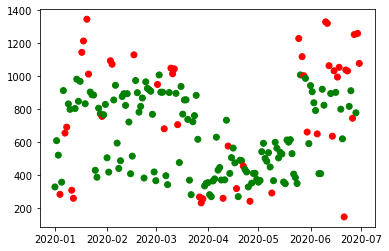

2 Distribution Services


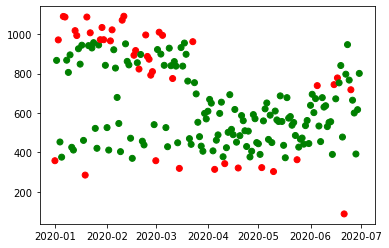

3 Commercial Services


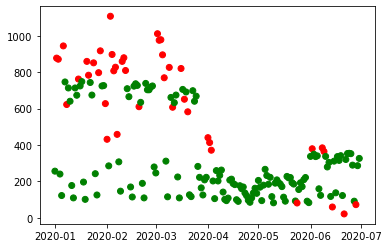

4 Solid Waste Management


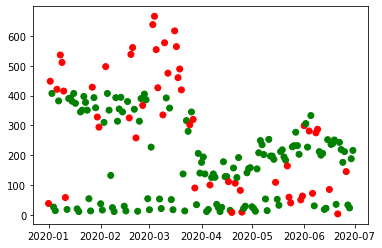

5 Revenue


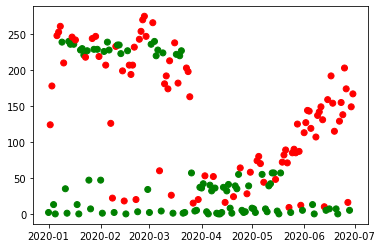

6 Recreation and Parks


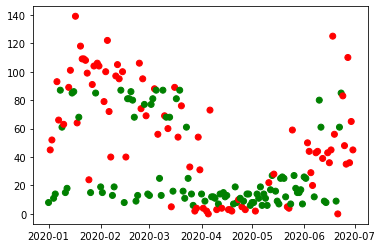

7 Home Ownership Transfer, Tenancy Management and Staff Housing


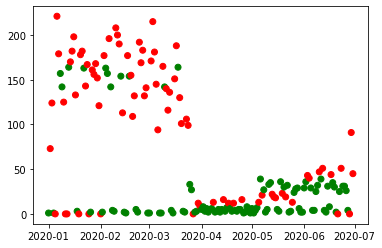

8 Technical Services


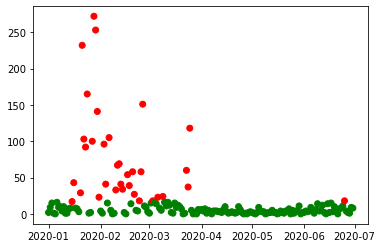

9 Customer Relations


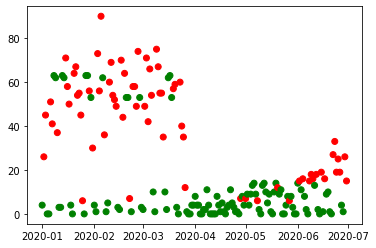

10 Operational Coordination


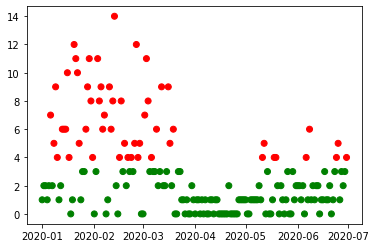

11 Transport Planning & Network Management


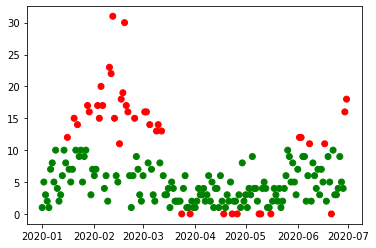

12 Unknown Department


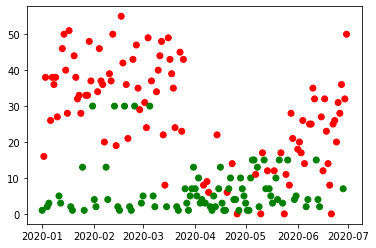

13 City Health


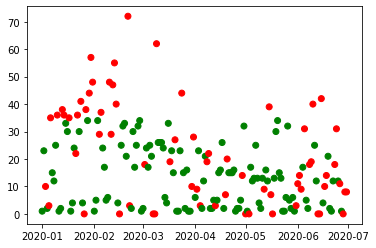

14 Roads Infrastructure Management


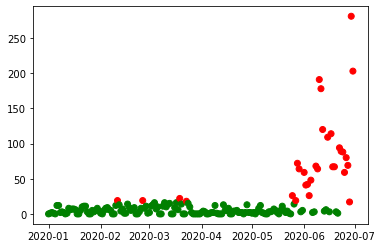

15 Valuations


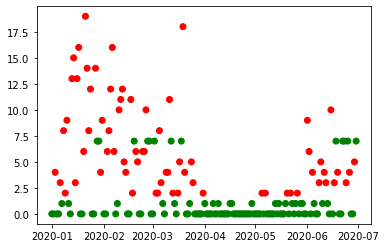

16 Property Management


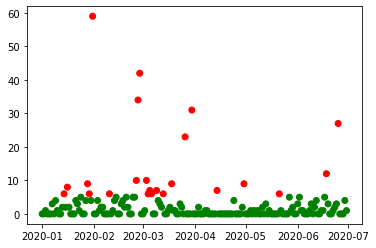

17 Social Development & Early Childhood Development


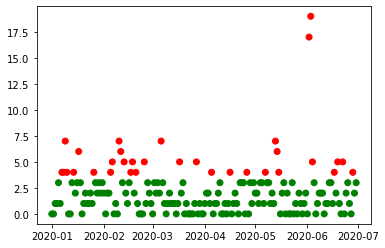

18 Legal Services


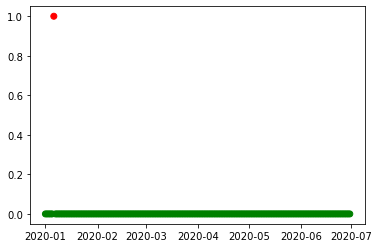

19 Bulk Services


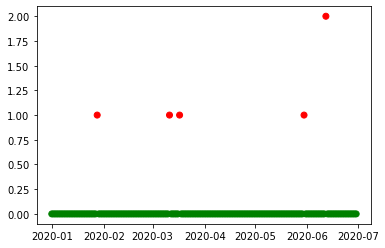

20 Fleet Management


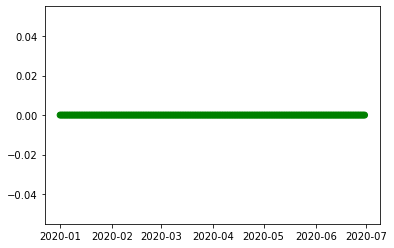

21 Environmental Management


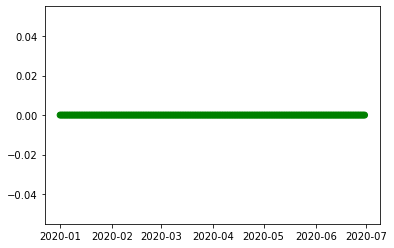

[[None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None]]

In [11]:
def plot_anomalies(iso_df, df_prep, col, i):
    '''
    plots normal aganinst anomalous observations colour-coded as green (normal) and red (anomaly)
    returns None, executes in place
    
    '''
    categories = iso_df[col].to_numpy()
    colormap = np.array(['g', 'r'])
    print(i + 1, col)
    plt.figure()
    plt.scatter(iso_df.index, df_prep[col], c = colormap[categories])
    plt.show()

[[plot_anomalies(iso_df, df_prep, col, i)] for col, i in zip(df_prep.columns, range(len(df_prep.columns)))]

## Final Answer (Motivation)

I focus on `Roads Infrastructure Management` as an illustrative example (plot fourteenth from the top).  I would motivate investigation to the department director as follows.  There is an upward trend towards the end of the semester.  As can be seen easily from the above plot, there were only a handful of anamolus volumes in the first four months, then in the last two months we see exponential growth in (*i*) the total number of anomalous volumes of requests, and (*ii*) the volumes are also much higher than usual.  Perhaps the roads are deteriorating more now as they are old and a new comprehensive refurbishment project should be undertaken before see an increase in road-related fatalities.

I also touch on `Unknown Department` (twelfth from the top).  The numbers warrant bringing this to the attention of the Infrastructure of Engineering team to fix the capture systems at source.  Is it a bug that causes so many queries in our dataset with department field balnk?  Or is it something else?  Either way this should be investigated and corrected in order to ensure improved data quality.